# Exploratory Data Analysis (EDA)

## Overview
Datasets are from Last.fm:
- `artists.dat`
- `tags.dat`
- `user_artists.dat` 
- `user_taggedartists.dat`
- `user_taggedartists-timestamps.dat`
- `user_friends.dat`

## Data Descriptions

1. **`artists.dat`**: contains information about music artists listened and tagged by the users.
   - columns: `id`, `name`, `url`, `pictureURL`

2. **`tags.dat`**: contains the set of tags available in the dataset.
   - columns: `tagID`, `tagValue`

3. **`user_artists.dat`**: contains the artists listened by each user, with a listening count for each [user, artist] pair.
   - columns: `userID`, `artistID`, `weight`

4. **`user_taggedartists.dat`**: contains the tag assignments of artists provided by each particular user wtih dates.
   - columns: `userID`, `artistID`, `tagID`, `day`, `month`, `year`

5. **`user_taggedartists-timestamps.dat`**: contains the tag assignments of artists provided by each particular user with the timestamps when the tag assignments were done.
   - columns: `userID`, `artistID`, `tagID`, `timestamp`

6. **`user_friends.dat`**: contains the friend relations between users in the database.
   - columns: `userID`, `friendID`

## Loading Data & Importing Libraries

In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import networkx as nx

sys.path.insert(1, os.path.join('..','scripts')) # add scripts folder to path so that python can find the GraphFuncs.py script

import GraphFuncs as gf # Script containing some functions I wrote

In [2]:
# import datasets
artists = pd.read_csv(os.path.join('..','data','artists.dat'), delimiter='\t')
tags = pd.read_csv(os.path.join('..','data','tags.dat'), delimiter='\t',encoding='ISO-8859-1')
user_artists = pd.read_csv(os.path.join('..','data','user_artists.dat'), delimiter='\t')
user_friends = pd.read_csv(os.path.join('..','data','user_friends.dat'), delimiter='\t')
user_taggedartists_timestamps = pd.read_csv(os.path.join('..','data','user_taggedartists-timestamps.dat'), delimiter='\t')
user_taggedartists = pd.read_csv(os.path.join('..','data','user_taggedartists.dat'), delimiter='\t')

## Initial Analysis
We will check for missing values and look at the size and structure of each dataset.

### Artists Dataset

In [3]:
print("Artists dataset:")
print(artists.info())
print(artists.head())

Artists dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17632 non-null  int64 
 1   name        17632 non-null  object
 2   url         17632 non-null  object
 3   pictureURL  17188 non-null  object
dtypes: int64(1), object(3)
memory usage: 551.1+ KB
None
   id               name                                         url  \
0   1       MALICE MIZER       http://www.last.fm/music/MALICE+MIZER   
1   2    Diary of Dreams    http://www.last.fm/music/Diary+of+Dreams   
2   3  Carpathian Forest  http://www.last.fm/music/Carpathian+Forest   
3   4       Moi dix Mois       http://www.last.fm/music/Moi+dix+Mois   
4   5        Bella Morte        http://www.last.fm/music/Bella+Morte   

                                          pictureURL  
0    http://userserve-ak.last.fm/serve/252/10808.jpg  
1  http://userserve-ak.last.fm/serv

The `id` and `name` columns will be needed to match artists to their corresponding artist ID in our recommendations. We can see that the columns `url` and `pictureURL` are not relevant for our collaborative filtering model. hence, we will drop these. There are missing values in the `pictureURL` column but we are removing this so the missing values will not affect our model. After cleaning, this dataset will have 2 columns and 17,632 rows.

### Tags Dataset

In [4]:
print("Tags dataset:")
print(tags.info())
print(tags.head())

Tags dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tagID     11946 non-null  int64 
 1   tagValue  11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB
None
   tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal


Both the `tagID` and `tagValue` columns will be needed for our model. The `tagID` gives the unique tag and the `tagValue` provides a description of the tag, for example, 'metal' or 'rock' which could indicate that a user likes these genres of music. There are no missing values in this dataset. There are 2 columns and 11,946 rows.

### User-Artists Dataset

In [5]:
print("User-Artists dataset:")
print(user_artists.info())
print(user_artists.head())

User-Artists dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
 2   weight    92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB
None
   userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983


The `userID` and `artistID` columns are used to identify the users and the artists that they interact with. The `weight` column represents the listening count, indicating how many times a user has listened to a specific artist. Clearly, the `weight` column will be important in building our recommender system, since the magnitude of the listening count can be used to determine a user's preference to listen to the given artist. There are no missing values in this dataset. There are 3 columns and 92,834 rows.

### User-Tagged Artists dataset

In [6]:
print("User-Tagged Artists dataset:")
print(user_taggedartists.info())
print(user_taggedartists.head())

User-Tagged Artists dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186479 entries, 0 to 186478
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   userID    186479 non-null  int64
 1   artistID  186479 non-null  int64
 2   tagID     186479 non-null  int64
 3   day       186479 non-null  int64
 4   month     186479 non-null  int64
 5   year      186479 non-null  int64
dtypes: int64(6)
memory usage: 8.5 MB
None
   userID  artistID  tagID  day  month  year
0       2        52     13    1      4  2009
1       2        52     15    1      4  2009
2       2        52     18    1      4  2009
3       2        52     21    1      4  2009
4       2        52     41    1      4  2009


The `userID` and `artistID` columns connect users to the artists that they have tagged, with the `tagID` column linking a specific tag with the artist. The `day`, `month`, and `year` columns show the exact date when a user tagged an artist. There are no missing values. There are 6 columns and 186,479 rows. The `day`, `month`, and `year` columns are not essential if our model does not include time-based features, however, we will keep them in place as we could possibly implement a time-based element into the model.

### User-Tagged Artists Timestamps dataset

In [7]:
print("User-Tagged Artists Timestamps dataset:")
print(user_taggedartists_timestamps.info())
print(user_taggedartists_timestamps.head())

User-Tagged Artists Timestamps dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186479 entries, 0 to 186478
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userID     186479 non-null  int64
 1   artistID   186479 non-null  int64
 2   tagID      186479 non-null  int64
 3   timestamp  186479 non-null  int64
dtypes: int64(4)
memory usage: 5.7 MB
None
   userID  artistID  tagID      timestamp
0       2        52     13  1238536800000
1       2        52     15  1238536800000
2       2        52     18  1238536800000
3       2        52     21  1238536800000
4       2        52     41  1238536800000


This is essentially just the `user_taggedartists.dat` dataset, except the `day`, `month`, and `year` columns have been replaced by a single timestamp. This has no missing values and has the same number of rows but less columns than the previous dataset. Hence, considering computational efficiency, this dataset is likely more useful to us than the previous, and if we were to implement time-based elements into our model, we will prefer this.  

### User-Friends dataset

In [8]:
print("User-Friends dataset:")
print(user_friends.info())
print(user_friends.head())

User-Friends dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25434 entries, 0 to 25433
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    25434 non-null  int64
 1   friendID  25434 non-null  int64
dtypes: int64(2)
memory usage: 397.5 KB
None
   userID  friendID
0       2       275
1       2       428
2       2       515
3       2       761
4       2       831


The `userID` column identifies the user, and the `friendID` column links them to their friends on the platform. This will be useful in analysing social interactions in our model and make recommendations based on the a user's friend's preferences. There are 2 columns and 25,434 rows. There are no missing values.

### **Conclusion of Initial Analysis**
We have looked at the basic properties of each dataset. There are many useful features of the data, including listening counts, tagged artists and user friendships. We need to clean the data by removing irrelevant columns.

We will summarise how we will use each dataset in our recommender system:

- **Artists dataset**: This dataset contains information about artists. It will be used to link artists to their corresponding `artistID` in the user-related datasets. There are no missing values, but we will remove the `url` and `pictureURL` columns, as these will not be relevant for our model.

- **Tags dataset**: This dataset contains the tags associated with artists. It will be used to link `tagID` to tags for the artists. There are no missing values, however, we need to ensure there are no irrelevant tags and remove duplicates if present.

- **User-Artists dataset**: This dataset will be used to shows which artists each user listens to, with the `weight` column representing listening counts. There are no missing values, but we need to check for and remove duplicates if present.

- **User-Tagged Artists dataset**: This dataset will not be used, since we will use the **User-Tagged Artists Timestamps dataset** instead as this contains the same amount of data but in a more compact structure with less columns.

- **User-Tagged Artists Timestamps dataset**: This dataset gives timestamped interactions of users with tagged artists. It can be used for time-sensitive recommendations, however, we may not use timestamps in our model. We will keep the timestamp column regardless, in case we decide to use time-sensitive recommendations later. There are no missing values, but we need to check for and remove duplicates if present. When implementing a model without time-sensitive recommendations, we will drop the `timestamp` column after cleaning.

- **User-Friends dataset**: This dataset shows the friendships between users and will be used to model user similarity or influence. There are no missing values, but we need to check for and remove duplicates if present.

In summary, each dataset is mostly clean but will require checking for duplicates and potential removal of unnecessary columns. The main goal is to keep only the relevant data for the recommendation system.


## Data Cleaning

In [9]:
# Drop irrelevant columns from the Artists dataset
artists_cleaned = artists.drop(columns=['url', 'pictureURL']).drop_duplicates(keep='first') 

# Drop the irrelevant columns in the Tags dataset
tags_cleaned = tags.drop_duplicates(keep='first') 

# For the User-Artists dataset, we can filter out rows with a weight of 0, as they show no meaningful interaction
# user_artists_cleaned = user_artists[user_artists['weight'] > 0]
user_artists_cleaned = user_artists.drop_duplicates(keep='first') 

# Drop duplicates from the User-Tagged Artists Timestamps dataset
user_taggedartists_timestamps_cleaned = user_taggedartists_timestamps.drop_duplicates(keep='first') 

# Convert timestamps from ms to datetime format
user_taggedartists_timestamps_cleaned['timestamp'] = pd.to_datetime(user_taggedartists_timestamps_cleaned['timestamp'], unit='ms')

# Drop duplicates from the User-Friends dataset
user_friends_cleaned = user_friends.drop_duplicates(keep='first') 


# Output cleaned datasets for inspection
print("Cleaned Artists dataset:", artists_cleaned.info(), artists_cleaned.head())
print("Cleaned Tags dataset:", tags_cleaned.info(), tags_cleaned.head())
print("Cleaned User-Artists dataset:", user_artists_cleaned.info(), user_artists_cleaned.head())
print("Cleaned User-Tagged Artists Timestamps dataset:", user_taggedartists_timestamps_cleaned.info(), user_taggedartists_timestamps_cleaned.head())
print("Cleaned User-Friends dataset:", user_friends_cleaned.info(), user_friends_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17632 non-null  int64 
 1   name    17632 non-null  object
dtypes: int64(1), object(1)
memory usage: 275.6+ KB
Cleaned Artists dataset: None    id               name
0   1       MALICE MIZER
1   2    Diary of Dreams
2   3  Carpathian Forest
3   4       Moi dix Mois
4   5        Bella Morte
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tagID     11946 non-null  int64 
 1   tagValue  11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB
Cleaned Tags dataset: None    tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal
<class 'p

We can see that there were no duplicates but the it is good to clean in practice. We have now prepared the data to be analysed.

## Data Analysis

### Unique Values

In [10]:
# Checking unique values in categorical columns
print("Unique artistIDs:", user_artists['artistID'].nunique())
print("Unique userIDs:", user_artists['userID'].nunique())
print("Unique tagIDs:", tags['tagID'].nunique())
print("Unique tagValues:", tags['tagValue'].nunique())


Unique artistIDs: 17632
Unique userIDs: 1892
Unique tagIDs: 11946
Unique tagValues: 11946


We can see that there are enough unique users, artists and tags for us to make a model.

### Top Artists & Top Tags

In [11]:
# Group by artistID and count the number of unique tags associated with each artist
tag_counts_per_artist = user_taggedartists_timestamps_cleaned.groupby('artistID')['tagID'].nunique().reset_index(name='num_tags')

# Merge with artist names to get the artist name from the artists_cleaned dataset
tag_counts_per_artist = tag_counts_per_artist.merge(artists_cleaned[['id', 'name']], left_on='artistID', right_on='id', how='left')

# Display top artists with the number of tags
print("Top Artists with the Most Tags:")
print(tag_counts_per_artist[['name', 'num_tags']].sort_values(by='num_tags', ascending=False).head(10))


Top Artists with the Most Tags:
                   name  num_tags
251      Britney Spears       329
254  Christina Aguilera       282
69         Depeche Mode       260
86            Lady Gaga       257
64              Madonna       249
130     Michael Jackson       199
48          Duran Duran       185
250             Rihanna       183
196         The Beatles       178
52        Kylie Minogue       173


In [12]:
# Counting the number of users interacting with each artist in the user_artists_cleaned dataset
user_interactions_per_artist = user_artists_cleaned.groupby('artistID')['userID'].nunique().reset_index(name='num_users')

# Merge with artist names to display artist names along with user interaction counts from the artists_cleaned dataset
user_interactions_per_artist = user_interactions_per_artist.merge(artists_cleaned[['id', 'name']], left_on='artistID', right_on='id', how='left')

# Display top artists by the number of users interacting
print("Top Artists with the Most User Interactions:")
print(user_interactions_per_artist[['name', 'num_users']].sort_values(by='num_users', ascending=False).head(10))


Top Artists with the Most User Interactions:
                   name  num_users
83            Lady Gaga        611
283      Britney Spears        522
282             Rihanna        484
221         The Beatles        480
294          Katy Perry        473
61              Madonna        429
327       Avril Lavigne        417
286  Christina Aguilera        407
184                Muse        400
492            Paramore        399


### Tags Distribution

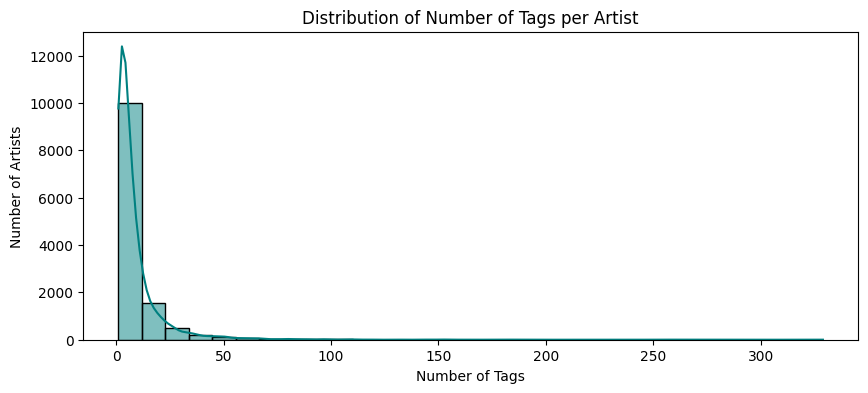

In [13]:
# Plotting the distribution of the number of tags per artist from tag_counts_per_artist
plt.figure(figsize=(10, 4))
sns.histplot(tag_counts_per_artist['num_tags'], kde=True, color='teal', bins=30)
plt.title('Distribution of Number of Tags per Artist')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Artists')
plt.show()


count    12523.000000
mean         8.763874
std         13.617504
min          1.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        329.000000
Name: num_tags, dtype: float64


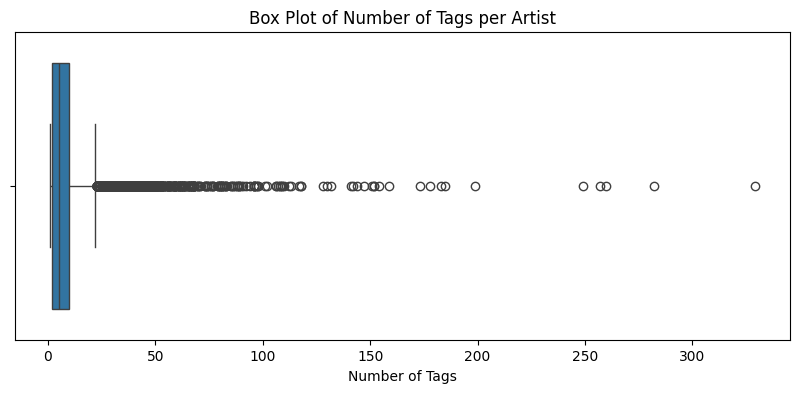

In [14]:
# Calculate descriptive statistics
stats = tag_counts_per_artist['num_tags'].describe()
print(stats)

# Apply log transformation (add 1 to avoid log(0) issues)
tag_counts_per_artist['log_num_tags'] = tag_counts_per_artist['num_tags'].apply(lambda x: np.log1p(x))

# Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=tag_counts_per_artist['num_tags'])
plt.title('Box Plot of Number of Tags per Artist')
plt.xlabel('Number of Tags')
plt.show()


### Listening Counts

In [15]:
# Overview of User-Artists 'weight' (listening counts)
print(user_artists_cleaned['weight'].describe())

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64


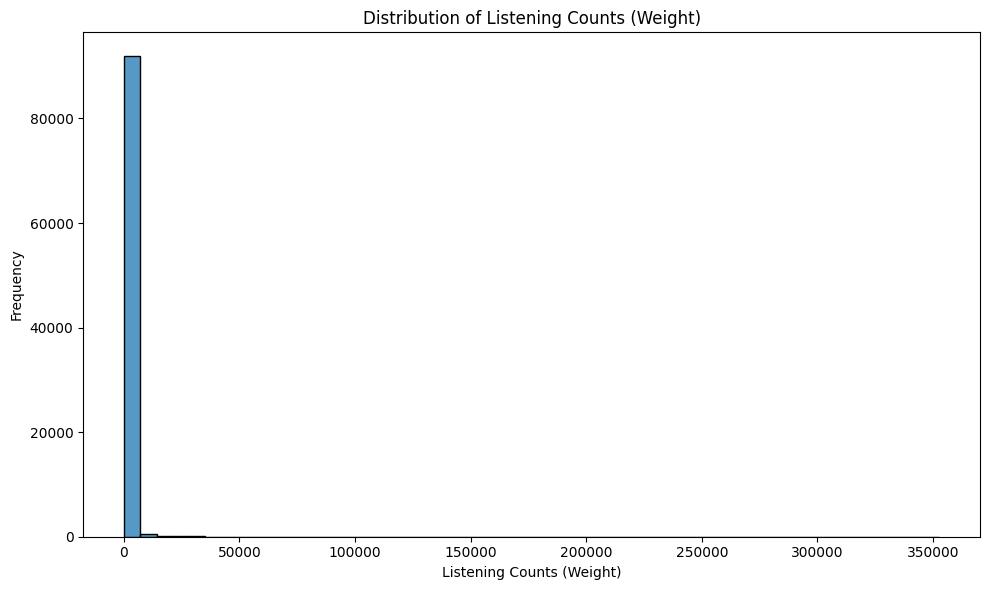

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of 'weight' (listening counts)
plt.figure(figsize=(10, 6))

# Histogram to show the distribution of listening counts (weights)
sns.histplot(user_artists_cleaned['weight'], bins=50, kde=False)

# Add labels and title
plt.title('Distribution of Listening Counts (Weight)')
plt.xlabel('Listening Counts (Weight)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


The listening counts are cleaerly very skewed to the left, with most counts in the 0 to 1000 range but with some extremely high counts. These may be outliers, but since it may be possible for someone to have listened to a user that many times we will not remove them.

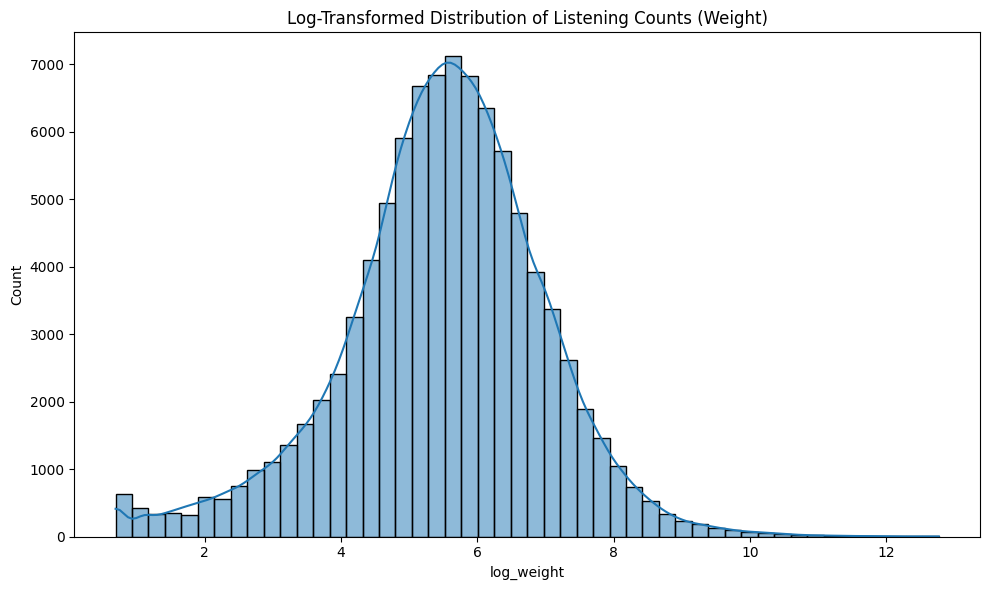

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply a log transformation with a small constant to avoid log(0)
user_artists_cleaned['log_weight'] = np.log(user_artists_cleaned['weight'] + 1)  # Adding 1 to avoid log(0)

# Plotting the distribution after log transformation
plt.figure(figsize=(10, 6))

# Distribution plot of the log-transformed weight
sns.histplot(user_artists_cleaned['log_weight'], bins=50, kde=True)

# Add labels and title
plt.title('Log-Transformed Distribution of Listening Counts (Weight)')
plt.tight_layout()
plt.show()


---

# Graphical Exploration

As briefly introduced in the Introduction, the LastFM dataset admits a rich graphical structure. There are also multiple options for how we could construct the graph. We will mainly consider a bipartite graph that takes advantage of user-artist, and user-user interactions. Both the users and the artists will be represented by vertices, with the listening activity of the users, and user friend relationships being represented as the edges. This data can be found in the `user_artists` and `user_friends` datasets. A tripartite graph could also be possible though, with users, artists, and tags all being considered as vertices, and edges connecting them all based on listening and tagging activity, found in the `user_artists` and `user_taggedartists` datasets respectively.

To see the rich graphical structure of this dataset, we will first construct a sub sample of the graph. Consider `user 2` and all their friends, and take the top 5 artists of each:

In [18]:
# Copy the datasets so we can edit them without editing the originals
user_artists_copy = user_artists.copy()
user_friends_copy = user_friends.copy()
user_taggedartists_copy = user_taggedartists.copy()
artists_copy = artists.copy()
tags_copy = tags.copy()

In [19]:
# Add designations so that we can distinguish between node types
if user_artists_copy['userID'][0] != 'user2':
    user_artists_copy['userID'] = 'user' + user_artists_copy['userID'].astype(str) # Place 'user' before each userID 
    user_artists_copy['artistID'] = 'artist' + user_artists_copy['artistID'].astype(str) # Place 'artist' before each artistID
    user_friends_copy['userID'] = 'user' + user_friends_copy['userID'].astype(str) # Place 'user' before each userID
    user_friends_copy['friendID'] = 'user' + user_friends_copy['friendID'].astype(str) # Place 'user' before each userID
    user_taggedartists_copy['artistID'] = 'artist' + user_taggedartists_copy['artistID'].astype(str) # Place 'artist' before each artistID
    user_taggedartists_copy['tagID'] = 'tag' + user_taggedartists_copy['tagID'].astype(str) # Place 'tag' before each tagID
    user_taggedartists_copy['userID'] = 'user' + user_taggedartists_copy['userID'].astype(str) # Place 'user' before each userID
    artists_copy['id'] = 'artist' + artists_copy['id'].astype(str) # Place 'artist' before each artistID
    tags_copy['tagID'] = 'tag' + tags_copy['tagID'].astype(str) # Place 'tag' before each tagID
    print('Designations added')
else:
    print('Designations already present')

Designations added


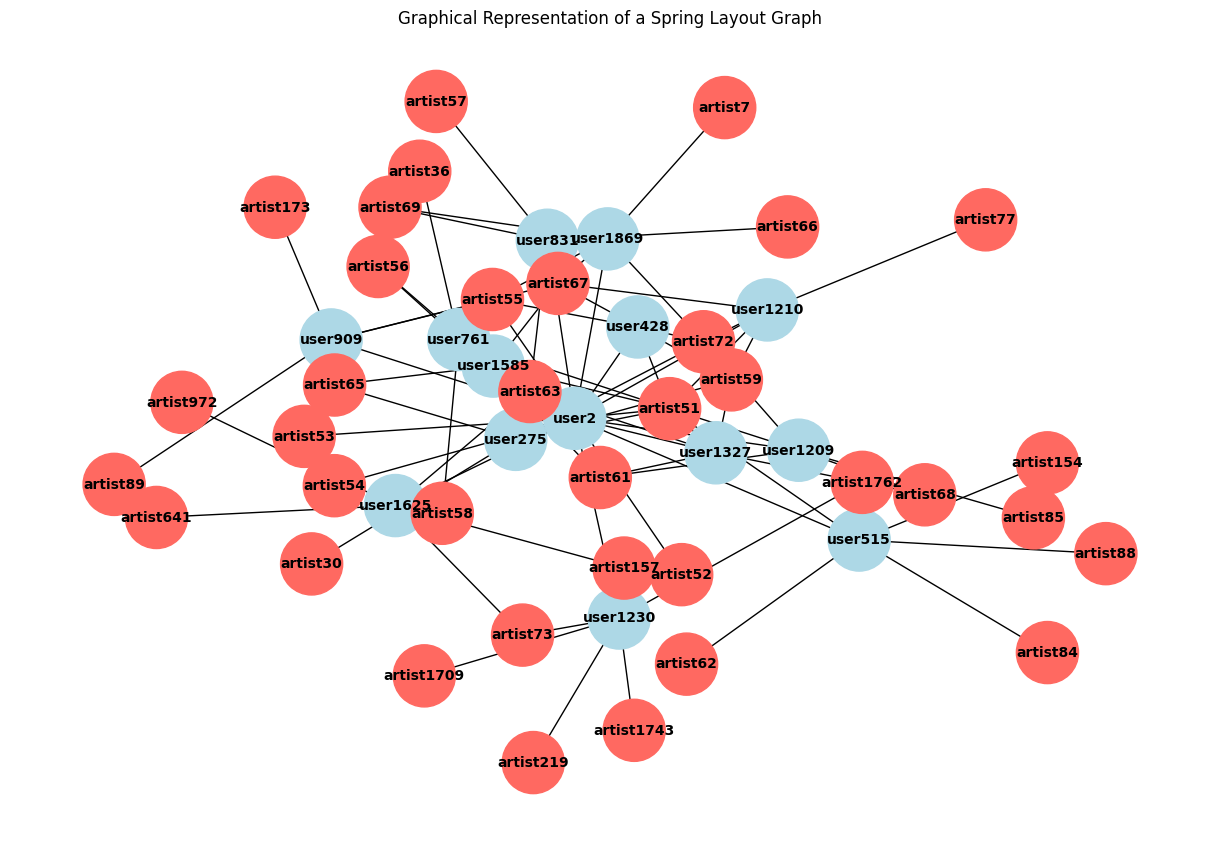

In [27]:
user2_friends = gf.get_friends('user2',user_friends_copy)
user2_friend_edges = pd.DataFrame([('user2',friend) for friend in user2_friends],columns=['src','dst'])
user2_friends.append('user2')
user2_friend_edges['relationship'] = 'friends'
edges_pd = user2_friend_edges

artists_list = []

for user in user2_friends:
    lst = gf.get_artists(user,user_artists_copy)
    templist = []
    for artist in lst[:5]:
        artists_list.append(artist)
        templist.append((user,artist,'listens'))
    edges_pd = pd.concat([edges_pd,pd.DataFrame(templist,columns=['src','dst','relationship'])],ignore_index=True)

user2_friends_df = pd.DataFrame(user2_friends,columns=['id'])
user2_friends_df['partition'] = 0
artists_df = pd.DataFrame(artists_list,columns=['id'])
artists_df['partition'] = 1

vertices_pd = pd.concat([user2_friends_df,artists_df],ignore_index=True)

gf.plot_spring_graph(vertices_pd,edges_pd)
# gf.plot_multipartite_graph(vertices_pd, edges_pd) # Multipartite graph is neater but loses some structure visibility and is not formatted well.

We see that just from these few users and their top 5 artists, we already have a detailed graph with lots of connections between nodes, showing just how rich the graphical representations can be. We will now take a look at the full dataset, and consider the possible graph structures and sizes.

In [30]:
# Define vertices
user_vertices = pd.DataFrame(user_artists_copy['userID'].unique(), columns = ['id']) # All users as nodes

artist_vertices = pd.DataFrame(artists_copy['id'].unique(), columns = ["id"]) # all artists as nodes

tag_vertices = pd.DataFrame(tags_copy['tagID'].unique(), columns = ["id"]) # all tags as nodes

# Define edges
user_artist_edges = user_artists_copy.drop('weight', axis = 1).rename(columns = {'userID' : 'src', 'artistID' : 'dst'})
user_artist_edges['relationship'] = 'listens' # user -> artist edges labelled 'listens'

user_tag_edges = user_taggedartists_copy.rename(columns = {'userID' : 'src', 'tagID' : 'dst'})
for col in ['day','month','year','artistID']:
    user_tag_edges = user_tag_edges.drop(col, axis = 1)
user_tag_edges['relationship'] = 'tag_used' # user -> tag edges labelled 'tag_used'

artist_tag_edges = user_taggedartists_copy.rename(columns = {'artistID' : 'src', 'tagID' : 'dst'})
for col in ['day','month','year','userID']:
    artist_tag_edges = artist_tag_edges.drop(col, axis = 1)
artist_tag_edges['relationship'] = 'tagged_as' # artist -> tag edges labelled 'tagged_as'

user_user_edges = user_friends_copy.rename(columns = {'userID' : 'src', 'friendID' : 'dst'})
user_user_edges['relationship'] = 'friend' # friend <-> friends edges labelled 'friend'

# Create vertex and edge datasets for a bi and tri partite graph
k2vertices = pd.concat([user_vertices,artist_vertices],ignore_index=True)
k2edges = pd.concat([user_artist_edges,user_user_edges],ignore_index=True)

k3vertices = pd.concat([user_vertices,artist_vertices,tag_vertices],ignore_index=True)
k3edges = pd.concat([user_artist_edges,user_tag_edges,artist_tag_edges,user_user_edges],ignore_index=True)

In [38]:
print(f'For a bipartite graph we have {k2vertices.shape[0]} vertices and {k2edges.shape[0]} edges.')
print(f'For a tripartite graph we have {k3vertices.shape[0]} vertices and {k3edges.shape[0]} edges.')

For a bipartite graph we have 19524 vertices and 118268 edges.
For a tripartite graph we have 31470 vertices and 491226 edges.


We see that the possible graph structures admitted by this dataset are extensive and therefore rich with information, showing us why GNNs have become so much more popular in recent years. In a later section we will explore the implementation of the LightGCN model on a bipartite graph to make predictions using collaborative information.